In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D, Rescaling # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from keras.layers import BatchNormalization

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

import json

from utils import plot_cm


c:\Users\EQ01\Documents\Programas\CONDA\Installation\envs\gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_shape = (58, 58)

adaptive_based_on_val = True  # if False, then uses ada_delta with decay, else uses stopping and decay based on val_acc

In [4]:
if adaptive_based_on_val:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        "images2/train",
        validation_split=0.1,
        subset="training",
        seed=20,
        color_mode='rgb',
        image_size=input_shape,
        label_mode="categorical",
        shuffle=True,
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        "images2/train",
        validation_split=0.1,
        subset="validation",
        seed=20,
        color_mode='rgb',
        image_size=input_shape,
        batch_size=64,
        label_mode="categorical",
        shuffle=False,
    )
else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        "images2/train",
        seed=42,
        color_mode='rgb',
        image_size=input_shape,
        label_mode="categorical",
        shuffle=True,
        batch_size=1000,
    )

Found 7462 files belonging to 9 classes.
Using 6716 files for training.
Found 7462 files belonging to 9 classes.
Using 746 files for validation.


In [5]:
model=Sequential()

model.add(Rescaling(1./127.5, offset=-1, input_shape=(input_shape[0], input_shape[1], 3)))
model.add(Conv2D(filters=64, kernel_size = (6,6), activation="relu", strides=(2, 2)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(9,activation="softmax"))
if adaptive_based_on_val:
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
else:
    ada_delta_ = keras.optimizers.Adadelta(lr=1, rho=0.95, epsilon=1e-08, decay=0.03)
    model.compile(loss="categorical_crossentropy", optimizer=ada_delta_, metrics=["accuracy"])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 58, 58, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 27, 27, 64)        6976      
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       7

In [7]:
if adaptive_based_on_val:
    es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
        )

    rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
        )
    h = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=[rp, es])
    # Do 5 epochs with a lower learning rate
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=["accuracy"])
    h = model.fit(val_ds, epochs=5)
else:
    h = model.fit(train_ds, epochs=140)

Epoch 1/200
210/210 [==============================] - 18s 28ms/step - loss: 2.0937 - accuracy: 0.2367 - val_loss: 4.7019 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/200
210/210 [==============================] - 5s 22ms/step - loss: 1.8737 - accuracy: 0.2786 - val_loss: 3.6856 - val_accuracy: 0.1139 - lr: 0.0010
Epoch 3/200
210/210 [==============================] - 5s 22ms/step - loss: 1.7839 - accuracy: 0.3139 - val_loss: 2.5319 - val_accuracy: 0.1139 - lr: 0.0010
Epoch 4/200
210/210 [==============================] - 5s 22ms/step - loss: 1.7047 - accuracy: 0.3316 - val_loss: 2.4833 - val_accuracy: 0.0241 - lr: 0.0010
Epoch 5/200
208/210 [============================>.] - ETA: 0s - loss: 1.6417 - accuracy: 0.3558
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
210/210 [==============================] - 5s 23ms/step - loss: 1.6433 - accuracy: 0.3557 - val_loss: 3.1383 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/200
210/210 [=======================

In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "images2/test",
    validation_split=None,
    seed=42,
    image_size=input_shape,
    batch_size=2000,
    label_mode="categorical",
    shuffle=False,
    color_mode='rgb',
)
for image_batch, labels_batch in test_ds:
  y_test_true = np.array(labels_batch)

Found 1865 files belonging to 9 classes.


In [9]:
y_pred = model.predict(test_ds) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]
Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test_treu = np.argmax(y_test_true, 1) # Decode Predicted labels

1/1 [==============================] - 6s 6s/step


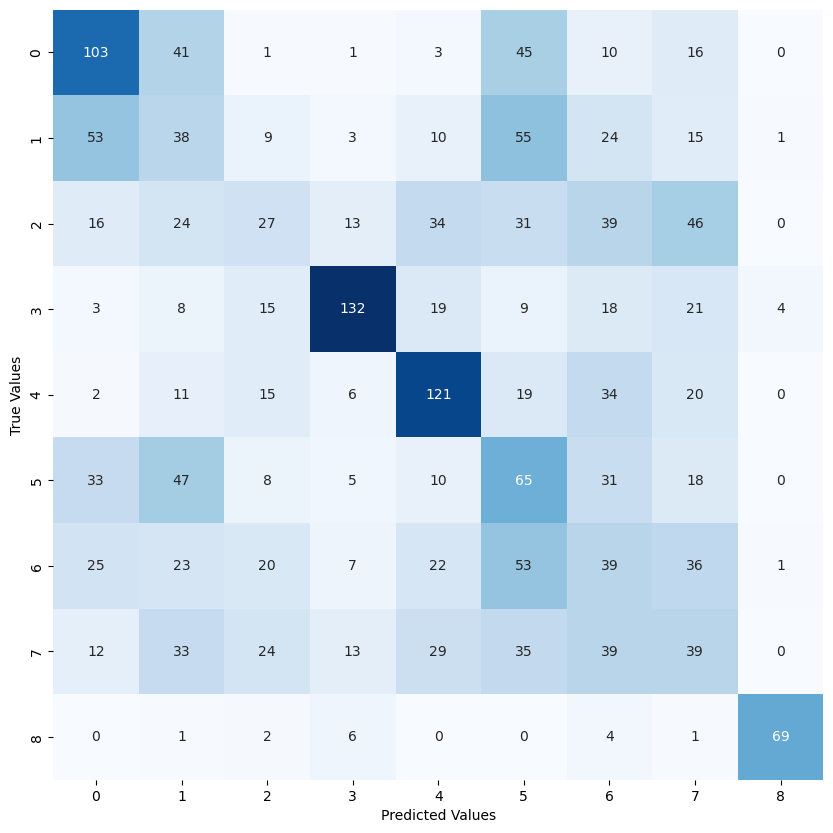

In [10]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

mat = confusion_matrix(Y_test_treu, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

In [11]:
f1_score(Y_test_treu, Y_pred, average='macro')

0.37564330394181716

In [12]:
with open('data/le_name_mapping.json', 'r') as f:
    mapping = json.load(f)
    le = LabelEncoder()
mapping['classes'] = [mapping[str(int(i))] for i in range(9)]
le.classes_ = np.array(mapping['classes'])

In [13]:
import importlib
import utils

importlib.reload(utils)
from utils import plot_cm

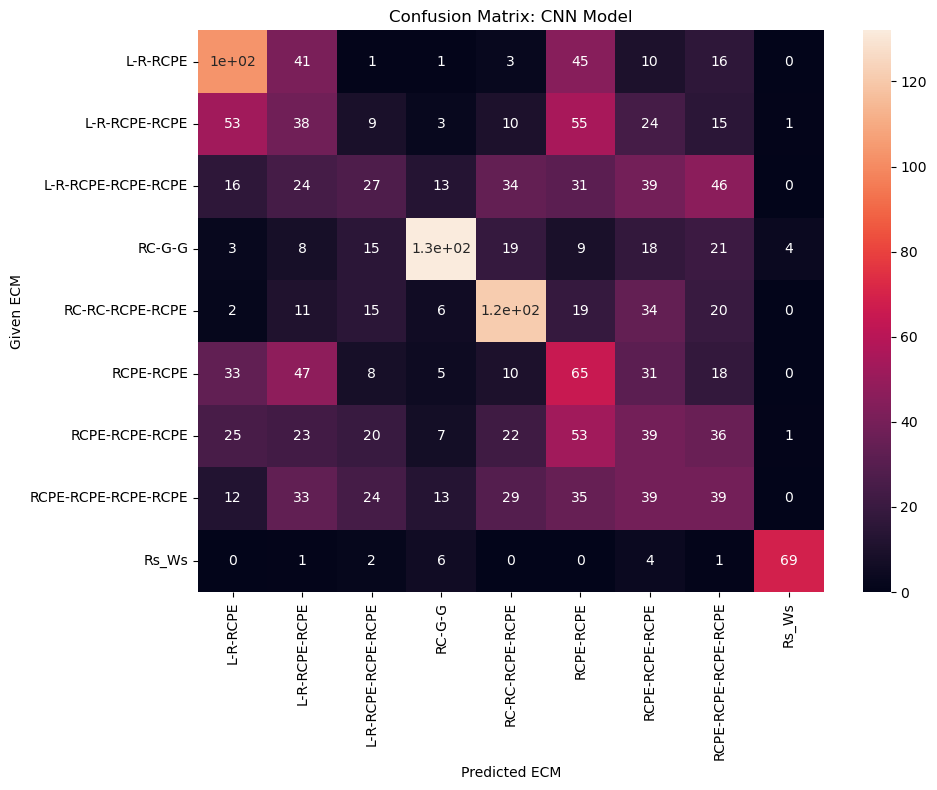

Test Accuracy: 0.37564330394181716


In [14]:
from importlib.resources import path


plot_cm(Y_test_treu, Y_pred, le, save=1, title='Confusion Matrix: CNN Model', figname='cnn_cm', save_path='figures/CNN/')

proportion_correct = f1_score(Y_test_treu, Y_pred, average='macro')
print('Test Accuracy: {}'.format(proportion_correct))